# Import and Preprocess Data

In [1]:
import pandas as pd
from unidecode import unidecode
import matplotlib.ticker as mtick

In [2]:
COLLECTIONS_PATH = "collections/"
DATASETS_PATH = "datasets/"

## specifying News Agency names and columns to import

In [3]:
na_dict = {"AFP1": "AFP", 
           "AFP2": "AFP", 
           "ANP": "ANP", 
           "ANSA": "ANSA", 
           "AP1": "AP", 
           "AP2": "AP", 
           "APA": "APA", 
           "Associated_Press": "AP", 
           "ATS1": "ATS",
           "ATS2": "ATS",
           "ATS3": "ATS",
           "Belga": "Belga", 
           "BTA": "BTA", 
           "CTK": "CTK", 
           "DDP-DAPD": "DDP-DAPD", 
           "DNB": "DNB",
           "Domei": "Domei", 
           "DPA": "DPA", 
           "Europapress": "Europapress", 
           "Extel": "Extel", 
           "Havas": "Havas",
           "Havasagentur": "Havas",
           "Interfax": "Interfax",
           "PAP": "PAP",
           "Reuter": "Reuters",
           "Reuters": "Reuters",
           "reutersche": "Reuters",
           "SPK": "SPK",
           "Stefani": "Stefani",
           "Tanjug": "Tanjug",
           "TASS": "TASS",
           "Telunion": "Telunion",
           "TT-Sweden": "TT",
           "UPI": "UP-UPI",
           "Wolff": "Wolff"
          
          }


#specify columns to import: all columns but "type" (empty) and last one (only title, indicating size of the collection)
cols = ['uid', 'language', 'title', 'size', 'country', 'newspaper',
       'issue', 'pages', 'nb_pages', 'relevance', 'year', 'is_on_front',
       'date', 'persons_mentioned', 'locations_mentioned', 'content',
       'access_right', 'content_provider', 'is_content_available',
       'collections']

#specify types for each column
dtypes = {'uid': str, 'language': str, 'title': str, 'size': int, 'country': str, 'newspaper': str,
       'issue': str, 'pages': str, 'nb_pages': int, 'relevance': float, 'year': int, 'is_on_front': bool,
       'date': object, 'persons_mentioned': str, 'locations_mentioned': str, 'content': str,
       'access_right': str, 'content_provider': str, 'is_content_available': str,
       'collections': str}

## Importing collections

In [4]:
#build full collection in one dataframe
df_all = pd.DataFrame()

for na_collection, na_name in na_dict.items():
    #import next news agency content
    path = COLLECTIONS_PATH + na_collection + ".zip"
    temp = pd.read_csv(path, compression="zip", sep=";", usecols=cols, dtype=dtypes)
    #save name of news agency
    temp["newsagency"] = na_name
    #add to rest
    df_all = pd.concat([df_all,temp])    

In [5]:
print(f"number of articles imported until now: {len(df_all)}")

number of articles imported until now: 3503618


### Disambiguation of "Mixed" collection

In [6]:
mixed_nas = {"afpreuters": ["AFP", "Reuters"], 
             "afpreuter": ["AFP", "Reuters"], 
             "atsafp": ["ATS", "AFP"], 
             "atsreuters": ["ATS", "Reuters"], 
             "atsreuter": ["ATS", "Reuters"], 
             "atsjafp": ["ATS", "AFP"], 
             "atsap": ["ATS", "AP"], 
             "aplddp": ["AP", "DDP-DAPD"], 
             "aplafp": ["AP", "AFP"],
             "afplap": ["AFP", "AP"], 
             "dpalafp": ["DPA", "AFP"], 
             "atsjreuter": ["ATS", "Reuters"], 
             "atsfafp": ["ATS", "AFP"], 
             "ddplap": ["DDP-DAPD", "AP"], 
             "aplsda": ["AP", "ATS"], 
             "aplddp": ["AP", "DDP-DAPD"], 
             "sdalafp": ["ATS", "AFP"], 
             "atsjred": ["ATS"], 
             "atsred": ["ATS"]}

In [7]:
len_before = len(df_all)

#import Mixed.zip file
path = COLLECTIONS_PATH + "Mixed.zip"
mixed = pd.read_csv(path, compression="zip", sep=";", usecols=cols, dtype=dtypes)
mixed = mixed[mixed["content"].notna()]

#normalize content column in a copy of Mixed
mixed_no_acc = mixed.copy()
mixed_no_acc["content"] = mixed_no_acc["content"].apply(lambda x: unidecode(x))

count = 0
for mixed_word, mixed_na_list in mixed_nas.items():
    #get all entries with the mixed_word in it
    temp = mixed[mixed_no_acc["content"].str.contains(mixed_word, case=False, na=False)]
    
    #first store mixed_na_list in a new column, then create one row per na entry (via explode)
    temp =  temp.assign(newsagency = [mixed_na_list] * len(temp))
    temp = temp.explode("newsagency", ignore_index=True)
    count += len(temp)
    
    #concatenate to existing df_all
    df_all = pd.concat([df_all,temp])

#delete duplicates
df_all.drop_duplicates(inplace=True)

print(f"#articles in Mixed.zip: {len(mixed)}, #rows stored (with duplicates): {count},\n\
final #rows stored (without duplicates): {len(df_all)-len_before}")

#articles in Mixed.zip: 5941, #rows stored (with duplicates): 14854,
final #rows stored (without duplicates): 2238


## add useful columns

In [8]:
#Pauline
def get_decade(year):
    return int((year//10)*10)

#add decade column
df_all["decade"] = df_all["year"].apply(lambda x: int(get_decade(x)))

## missing values

In [9]:
df_all.isnull().sum()

uid                          0
language                     0
title                   314285
size                         0
country                     64
newspaper                    0
issue                        0
pages                        0
nb_pages                     0
relevance                    0
year                         0
is_on_front                  0
date                         0
persons_mentioned       893605
locations_mentioned     352461
content                 174710
access_right                 0
content_provider             0
is_content_available    173216
collections                  0
newsagency                   0
decade                       0
dtype: int64

In [10]:
no_content = df_all[df_all["content"].isnull()]
print(f"#articles without content: {len(no_content)}, percentage: {len(no_content)/len(df_all)}")
no_content.head()

#articles without content: 174710, percentage: 0.049833763851110824


,uid,language,title,size,country,newspaper,issue,pages,nb_pages,relevance,...,date,persons_mentioned,locations_mentioned,content,access_right,content_provider,is_content_available,collections,newsagency,decade
111034,IMP-1955-04-01-a-i0061,en,Le « blocus » de Berlin,1,CH,IMP,IMP-1955-04-01-a,5,1,0.0,...,1955-04-01T00:00:00Z,NaN,NaN,NaN,OpenPrivate,SNL,y,"local-ps-RlHa2EhD,local-IIV_6APb-4hURA0iX",AFP,1950
111035,IMP-1955-04-01-a-i0067,en,Une protestation des Occidentaux,1,CH,IMP,IMP-1955-04-01-a,5,1,0.0,...,1955-04-01T00:00:00Z,NaN,NaN,NaN,OpenPrivate,SNL,y,"local-ps-RlHa2EhD,local-IIV_6APb-4hURA0iX",AFP,1950
111036,IMP-1955-04-01-a-i0068,en,Eisenhower ne s'est pas prononcé sur la défens...,1,CH,IMP,IMP-1955-04-01-a,5,1,0.0,...,1955-04-01T00:00:00Z,NaN,NaN,NaN,OpenPrivate,SNL,y,"local-ps-RlHa2EhD,local-IIV_6APb-4hURA0iX",AFP,1950
111037,IMP-1955-04-01-a-i0089,en,Trois dames carbonisées,1,CH,IMP,IMP-1955-04-01-a,7,1,0.0,...,1955-04-01T00:00:00Z,NaN,NaN,NaN,OpenPrivate,SNL,y,"local-ps-RlHa2EhD,local-IIV_6APb-4hURA0iX",AFP,1950
111038,IMP-1955-04-01-a-i0344,en,Les préparatifs se poursuivent pour une confér...,1,CH,IMP,IMP-1955-04-01-a,26,1,0.0,...,1955-04-01T00:00:00Z,NaN,Allemagne|PARIS,NaN,OpenPrivate,SNL,y,"local-IIV_6APb-IaAgqTUh,local-IIV_6APb-X0x8Swx...",AFP,1950


### deleting articles without content

In [11]:
df_all = df_all[df_all["content"].notna()]
print("After deleting articles without content:")
df_all.isnull().sum()

After deleting articles without content:


uid                          0
language                     0
title                   312237
size                         0
country                     64
newspaper                    0
issue                        0
pages                        0
nb_pages                     0
relevance                    0
year                         0
is_on_front                  0
date                         0
persons_mentioned       817600
locations_mentioned     325198
content                      0
access_right                 0
content_provider             0
is_content_available         0
collections                  0
newsagency                   0
decade                       0
dtype: int64

## Check for downloading error

In [12]:
#check if high number are due to error during download
Europapress = pd.read_csv(COLLECTIONS_PATH+"Europapress.zip", compression="zip", sep=";", usecols=cols, dtype=dtypes)
Europapress0 = pd.read_csv(COLLECTIONS_PATH+"Europapress-0.zip", compression="zip", sep=";", usecols=cols, dtype=dtypes)

print(f"Europapress #articles without content: {Europapress['content'].isna().sum()} of {len(Europapress)}\n\
Europapress0 #articles without content: {Europapress0['content'].isna().sum()} of {len(Europapress0)}")
#> not a download error

Europapress #articles without content: 7624 of 7929
Europapress0 #articles without content: 7624 of 7929


## Missing value statistics

### helper function

In [13]:
def percentage_barplot(df_content, df_no_content, groupby_col, figsize=None):
    df = df_content[[groupby_col, "uid"]].groupby(groupby_col).count().rename(columns={"uid":"has_content"})
    #join with no_content dataframe which is also grouped by newsagencies
    df = df.join(df_no_content[[groupby_col, "uid"]].groupby(groupby_col).count().rename(columns={"uid":"no_content"}),
                 how="outer")
    df = df.fillna(0)

    #column: percentage of entries without content    
    df["perc_no_content"] = df.apply(lambda x: x.no_content/(x.has_content + x.no_content), axis=1)
    ax = df["perc_no_content"].plot.bar(figsize=figsize, title="% of missing content per "+groupby_col,
                                        ylabel="% of articles with missing content")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    return df

### statistics

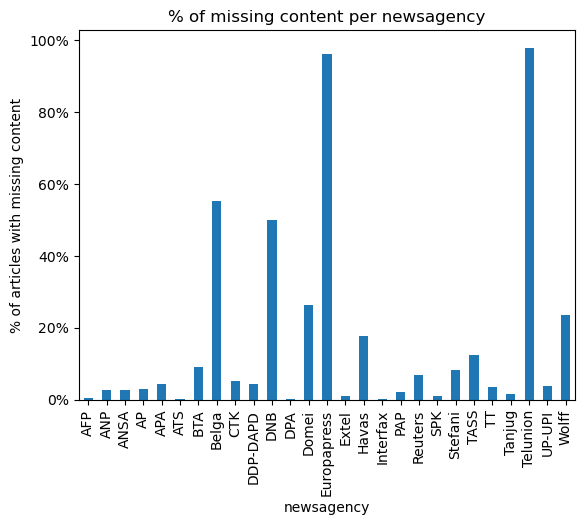

In [14]:
Newsagencies = percentage_barplot(df_all, no_content, "newsagency")

In [15]:
Newsagencies

,has_content,no_content,perc_no_content
newsagency,,,
AFP,662985,2272,0.003415
ANP,4878,139,0.027706
ANSA,9624,258,0.026108
AP,506439,15649,0.029974
APA,8426,373,0.042391
ATS,1032857,2692,0.002600
BTA,1963,193,0.089518
Belga,4900,6054,0.552675
CTK,4397,238,0.051348


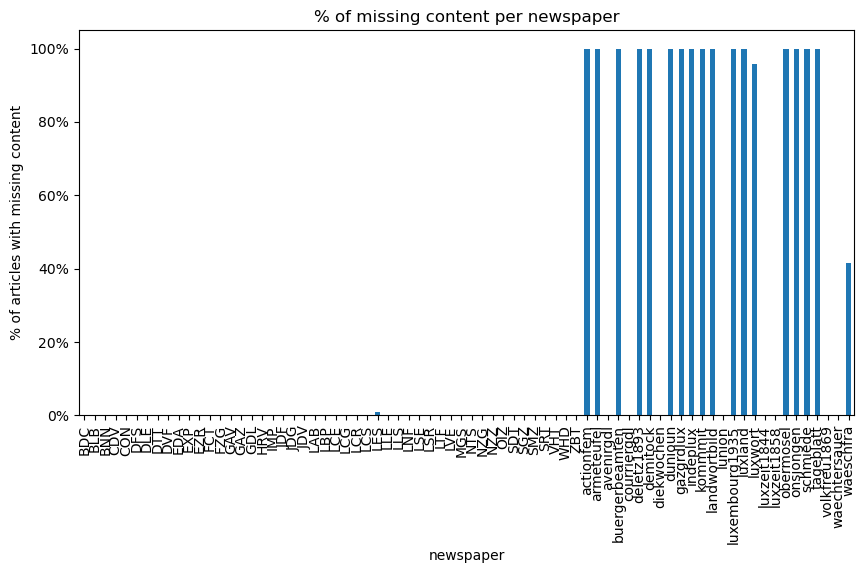

In [16]:
_ = percentage_barplot(df_all, no_content, "newspaper", figsize=(10,5))

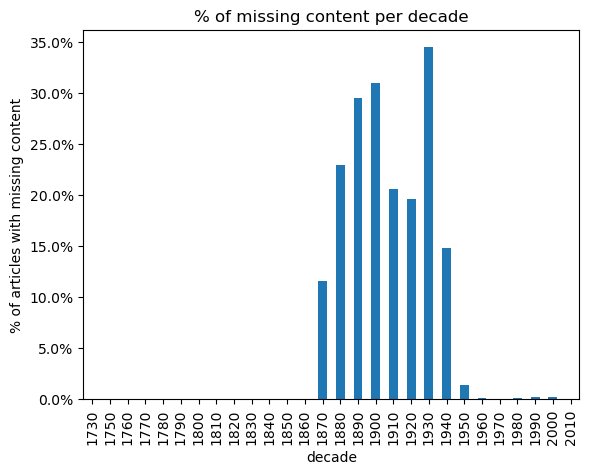

In [17]:
_ = percentage_barplot(df_all, no_content, "decade")

## Special case: Luxembourg

In [18]:
#a lot of articles with no content are from luxemburg
no_content["country"].value_counts()

LU    173216
CH      1494
Name: country, dtype: int64

In [19]:
no_content_lux = no_content[no_content["country"]=="LU"]
no_content_lux.head()

,uid,language,title,size,country,newspaper,issue,pages,nb_pages,relevance,...,date,persons_mentioned,locations_mentioned,content,access_right,content_provider,is_content_available,collections,newsagency,decade
259206,buergerbeamten-1899-11-21-a-i0009,de,Publicité 2 Page 3,95,LU,buergerbeamten,buergerbeamten-1899-11-21-a,3,1,0.0,...,1899-11-21T00:00:00Z,NaN,NaN,NaN,Closed,BNL,NaN,local-IIV_6APb-4hURA0iX,AFP,1890
259207,buergerbeamten-1901-12-14-a-i0009,de,Publicité 12 Page 4,237,LU,buergerbeamten,buergerbeamten-1901-12-14-a,4,1,0.0,...,1901-12-14T00:00:00Z,NaN,NaN,NaN,Closed,BNL,NaN,local-IIV_6APb-4hURA0iX,AFP,1900
259208,buergerbeamten-1904-04-09-b-i0015,de,Publicité 4 Page 3,340,LU,buergerbeamten,buergerbeamten-1904-04-09-b,3,1,0.0,...,1904-04-09T00:00:00Z,G. Grand|Jules GEHLEN,Olympia,NaN,Closed,BNL,NaN,local-IIV_6APb-4hURA0iX,AFP,1900
259209,buergerbeamten-1905-11-25-a-i0007,de,Was in der Welt vorgeht. Ausland=Nachrichten.,1226,LU,buergerbeamten,buergerbeamten-1905-11-25-a,2,1,0.0,...,1905-11-25T00:00:00Z,NaN,Col|Schweiz|Portugal|Deutschland|Mau|Deutschla...,NaN,Closed,BNL,NaN,local-IIV_6APb-4hURA0iX,AFP,1900
259210,buergerbeamten-1906-03-29-a-i0001,de,"Wie im „Luxemburger Wort"" polemisiert wird.",1496,LU,buergerbeamten,buergerbeamten-1906-03-29-a,"1,2",2,0.0,...,1906-03-29T00:00:00Z,Rod Brnfleur|Mille Colonnes,Lage|Marl,NaN,Closed,BNL,NaN,"local-stkr-Mdv8e1pJ,local-stkr-yQ_Bw9iY,local-...",AFP,1900


In [20]:
#compare article lengths in no_content for CH vs. LU
artLu_smaller10 = no_content_lux[no_content_lux["size"]<10]
artCh_equal1 = no_content.loc[(no_content["country"]=="CH") & (no_content["size"]==1)]

print(f"#articles from Luxembourg with article size <10: {len(artLu_smaller10)}\t\
({round(len(artLu_smaller10)/len(no_content_lux)*100, 2)}% of all missing content articles from LU)") #-> most of the LU articles have content size > 1
print(f"#articles from Switzerland with article size =1: {len(artCh_equal1)}\t\
({round(len(artCh_equal1)/len(no_content.loc[no_content['country']=='CH'])*100)}% of all missing content articles from CH)") #-> most of the CH articles have content size = 1

#articles from Luxembourg with article size <10: 93	(0.05% of all missing content articles from LU)
#articles from Switzerland with article size =1: 1114	(75% of all missing content articles from CH)


## Re-Including articles with missing content from LU
(bug in impresso, will get content afterwards)

In [21]:
df_all = pd.concat([df_all, no_content_lux])
df_all.tail()

,uid,language,title,size,country,newspaper,issue,pages,nb_pages,relevance,...,date,persons_mentioned,locations_mentioned,content,access_right,content_provider,is_content_available,collections,newsagency,decade
91602,tageblatt-1950-12-27-a-i0092,fr,Madame Vve Pierre Peters née Thérèse WOLFF,153,LU,tageblatt,tageblatt-1950-12-27-a,6,1,0.0,...,1950-12-27T00:00:00Z,Madame Vve Pierre Peters|Thérèse WOLFF|Mme Vve...,NaN,NaN,Closed,BNL,NaN,local-IIV_6APb--IL_DPHu,Wolff,1950
93211,waeschfra-1879-09-06-a-i0014,fr,Communiqué.,303,LU,waeschfra,waeschfra-1879-09-06-a,4,1,0.0,...,1879-09-06T00:00:00Z,Dom Scot,Vienne|Rome|Kant,NaN,Closed,BNL,NaN,local-IIV_6APb--IL_DPHu,Wolff,1870
93212,waeschfra-1879-12-27-a-i0012,de,Paffenränke.,342,LU,waeschfra,waeschfra-1879-12-27-a,3,1,0.0,...,1879-12-27T00:00:00Z,Johann Baptist Wolff|Michel Unsen|A. Kotzebue|...,Pasto|Paris,NaN,Closed,BNL,NaN,local-IIV_6APb--IL_DPHu,Wolff,1870
93213,waeschfra-1880-09-11-a-i0021,de,!! Pfäffische Unverschämtheit !!,306,LU,waeschfra,waeschfra-1880-09-11-a,2,1,0.0,...,1880-09-11T00:00:00Z,Pastor von Moersdorff|B. WolfF,NaN,NaN,Closed,BNL,NaN,local-IIV_6APb--IL_DPHu,Wolff,1880
93214,waeschfra-1881-08-27-a-i0013,de,Actualität.,244,LU,waeschfra,waeschfra-1881-08-27-a,3,1,0.0,...,1881-08-27T00:00:00Z,I. B. Wulff,Lehre|Kaplan|Lehre,NaN,Closed,BNL,NaN,local-IIV_6APb--IL_DPHu,Wolff,1880


# Grouping Dataframe by articles

In [22]:
#group by article, using all columns but the newsagency 
#       (as all the others should contain same column contents for the same article)
groupby_cols = cols.copy()
groupby_cols.append("decade")
df_articles = df_all.groupby(groupby_cols, dropna=False)["newsagency"].apply(list).reset_index()

# create one column with list of news agencies, one with string where NA's are seperated by commata
df_articles.rename({"newsagency":"newsagency_list"}, axis=1, inplace=True)
df_articles["newsagencies"] = df_articles["newsagency_list"].apply(lambda x: ", ".join(x))

#statistics
print(f"unique: {len(df_articles)}, news agency mentions: {len(df_all)},\n\
percentage of articles only contained in one collection: {round(len(df_articles)/len(df_all)*100)}%")

unique: 2814382, news agency mentions: 3504362,
percentage of articles only contained in one collection: 80%


## creating small samples

In [23]:
df_all_sample = df_all.sample(n=100, random_state=2023)
df_articles_sample =df_articles.sample(n=100, random_state=2023)

## saving Dataframes

In [24]:
#to pickle
df_all.to_pickle(DATASETS_PATH + "df_all.pkl")
df_articles.to_pickle(DATASETS_PATH + "df_articles.pkl")
df_all_sample.to_pickle(DATASETS_PATH + "df_all_selection.pkl")
df_articles_sample.to_pickle(DATASETS_PATH + "df_articles_selection.pkl")